In [38]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import datetime

########## INPUT #############
# it = int(sys.argv[1])-1
# f_varlist = Path(sys.argv[2])

it=0
f_varlist = Path('../data/PriorModel/varlist.pkl')
print(it,f_varlist)

########## INPUT #############


if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    lithdir = datadir.joinpath('lith/sgems/')
    GISdir = datadir.joinpath('GIS')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    lithdir = datadir.joinpath('lith/sgems/')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')

nmgwmdir_empty = datadir.joinpath('nmgwmdir_empty') #<-- removed everything but DIS
nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')

import config
import utils


#%% Useful functions
def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))



if len(f_varlist.name.split('.'))>1:
    nam = f_varlist.name.split('.')[0]
else:
    nam = f_varlist.name
varlist = load_obj(f_varlist.parent,nam)
ts = make_timestamp()


##Loading
modelname = 'NM'
model_ws_read = workdir.joinpath("NM")
m= flopy.seawat.Seawat.load('NM.nam',exe_name=config.swexe, model_ws=model_ws_read.as_posix())
rows = np.load(model_ws_read.joinpath('rows.npy'))
starttime = np.load(model_ws_read.joinpath('starttime.npy'))
layer_mapping_ind_full = np.load(GISdir.joinpath('layer_mapping_ind_full.npy'))                                 
layer_mapping_ind = layer_mapping_ind_full[:,rows,:]
# m = flopy.seawat.Seawat(modelname, exe_name=config.swexe, model_ws=model_ws.as_posix(),verbose=verbose)


##Make temp folder for writing
model_ws = workdir.joinpath('NM_{}'.format(it))
if not model_ws.exists():
    model_ws.mkdir()
m.model_ws = model_ws.as_posix()



##Unpack vars
por_sand = varlist['por_sand'][it] #done
por_clay = varlist['por_clay'][it] #done
aL = varlist['aL'][it] #done
kvh = varlist['kvh'][it] #done
kh_sand_180 = varlist['kh_sand_180'][it] #done
kh_clay_180 = varlist['kh_clay_180'][it]*100 #done 
kh_sand_400 = varlist['kh_sand_400'][it] #done
kh_clay_400 = varlist['kh_clay_400'][it]*100 #done *
kh_lay1     = varlist['kh_lay1'][it] #done 
DSA_head    = varlist['DSA_head'][it] #done 


hk_aquitard = min(kh_clay_180,kh_clay_400)
hk = np.zeros_like(layer_mapping_ind_full,dtype=np.float)
lith_180 = np.load(lithdir.joinpath('snesim','mps180_{}.npy'.format(it))).astype(np.float)
lith_400 = np.load(lithdir.joinpath('sisim','sisim400_{}.npy'.format(it))).astype(np.float)



lith_180[lith_180==1.] = kh_sand_180
lith_180[lith_180==0.] = kh_clay_180 
lith_400[lith_400==1.] = kh_sand_400
lith_400[lith_400==0.] = kh_clay_400 


hk[np.where(layer_mapping_ind_full==0)] = 1000
hk[np.where(layer_mapping_ind_full==1)] = kh_lay1*.1
hk[np.where(layer_mapping_ind_full==2)] = hk_aquitard
hk[np.where(layer_mapping_ind_full==3)] = lith_180[np.where(layer_mapping_ind_full==3)]
hk[np.where(layer_mapping_ind_full==4)] = hk_aquitard
hk[np.where(layer_mapping_ind_full==5)] = lith_400[np.where(layer_mapping_ind_full==5)]
hk[np.where(layer_mapping_ind_full>5)] = 1.


prsity = np.zeros_like(layer_mapping_ind_full,dtype=np.float)
prsity[np.isin(hk,(kh_lay1,kh_sand_180,kh_sand_400))]=por_sand
prsity[np.where(prsity==0.)]=por_clay


hk = hk[:,rows,:]
prsity = prsity[:,rows,:]

hk = kh_sand_180
prsity=.25

chd_data_orig = m.chd.stress_period_data
chd_data = {}
for per in range(m.dis.nper):
    chd_per=[]
    for val in chd_data_orig.data[0]:
        chd_per.append([val[0],val[1],val[2],DSA_head,DSA_head])
    chd_data[per] = chd_per
    


0 ../data/PriorModel/varlist.pkl

changing model workspace...
   ../work/NM_0

changing model workspace...
   ../work/NM_0

changing model workspace...
   ../work/NM_0


In [39]:

lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=kvh, ipakcb=m.lpf.ipakcb,laytyp=0,laywet=0,
                              ss=m.lpf.ss.array,sy=m.lpf.sy.array)

try:
    sconc= m.btn.sconc.array
except:
    sconc= m.btn.sconc[0].array
btn = flopy.mt3d.Mt3dBtn(m,
                         laycon=m.btn.laycon.array, htop=m.btn.htop.array,
                         dz=m.dis.thickness.get_value(), prsity=prsity, icbund=m.btn.icbund.array,
                         sconc=sconc, nprs=1,timprs=m.btn.timprs)

dsp = flopy.mt3d.Mt3dDsp(m, al=aL,dmcoef=2.0e-9)
chd = flopy.modflow.ModflowChd(m, stress_period_data=chd_data)


writeyn= True
runyn = True
#Write input
if writeyn:
    m.write_input()
    
    
# Try to delete the output files, to prevent accidental use of older files
f_delete = [os.path.join(m.model_ws,'MT3D.CNF'),
            os.path.join(m.model_ws,'MT3D001.MAS'),
            os.path.join(m.model_ws, 'MT3D001.UCN'),
            os.path.join(m.model_ws, modelname + '.hds'),
            os.path.join(m.model_ws, modelname + '.cbc')]

for f in f_delete:
    try:
        os.remove(f)
    except:
        pass

#%%



****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtbtn.Mt3dBtn'> <class 'flopy.mt3d.mtbtn.Mt3dBtn'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtdsp.Mt3dDsp'> <class 'flopy.mt3d.mtdsp.Mt3dDsp'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfchd.ModflowChd'> <class 'flopy.modflow.mfchd.ModflowChd'>
replacing existing Package...


In [40]:
plt.figure()
plt.imshow(np.log10(hk)[:,0,:],vmin=-2,vmax=3)
plt.gca().set_aspect(10)
plt.colorbar()

IndexError: invalid index to scalar variable.

<Figure size 432x288 with 0 Axes>

In [41]:
if runyn:
    v = m.run_model(silent=False, report=True)
    for idx in range(-3, 0):
        print(v[1][idx])
else:
    print('Not running model!')

exportdir = outputdir.joinpath('NM')
if not exportdir.exists():
    exportdir.mkdir(parents=True)

date_per = starttime + np.cumsum(m.dis.perlen.array)/365
survey_date = 2017.25
survey_kper = np.argmin(np.abs(date_per-survey_date))

fname = os.path.join(m.model_ws, 'MT3D001.UCN')
totim = flopy.utils.binaryfile.UcnFile(fname).get_times()[-1]
conc_fname = 'conc{}_{}_totim{}.UCN'.format(
    it, ts, str(int(totim)))

utils.copy_rename(fname,
                 exportdir.joinpath(conc_fname))
conc = flopy.utils.binaryfile.UcnFile(fname).get_data(kstpkper=(0,survey_kper))
np.save(exportdir.joinpath(conc_fname[:-4] + '.npy'),conc)

FloPy is using the following  executable to run the model: /usr/local/bin/MODFLOW/swtv4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: NM.nam                                                                                                                                                                                                  
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/07/02 10:39:06


 STRESS PERIOD NO.    1

  STRESS PERIOD

In [44]:
conc = flopy.utils.binaryfile.UcnFile(fname).get_data(kstpkper=(0,53))
conc[conc > 100]=np.nan



Text(0.5,0,'X UTM (m)')

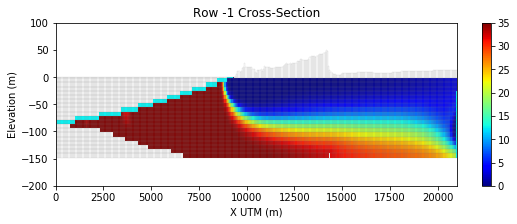

In [49]:
from matplotlib import cm

slicetype='Row'
slicenum= -1

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.ModelCrossSection(model=m, line={slicetype: slicenum})
# xsect.plot_ibound()
xsect.plot_grid(linewidth=.1)
# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
# xsect.contour_array(conc,cmap='jet',levels=np.array([.05,.5,.95])*Csalt)
csa = xsect.plot_array(conc,cmap='jet',vmin=0.,vmax=35.)
# csa = xsect.plot_array(hd)

c = plt.colorbar(csa)
# wel = xsect.plot_bc("CHD")
wel = xsect.plot_bc("GHB")



t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-200,100))
plt.xlabel('X UTM (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')